<a href="https://colab.research.google.com/github/juminsuh/Reinforcement_Learning/blob/main/%5B24_1_%EC%A0%95%EA%B7%9C%EC%84%B8%EC%85%98%5DDeepSARSA_%EC%A3%BC%EB%AF%BC%EC%84%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from typing import Tuple

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load env

In [ ]:
# change directory
os.chdir('/content/drive/MyDrive/24-1/강화학습세션/환경')

In [ ]:
! python GridWorldEnvironment3.py

In [ ]:
from GridWorldEnvironment3 import GridWorldEnvironment

# DeepSARSA

In [10]:
# 입력을 상태의 크기, 행동의 크기로 받고 큐함수를 출력하는 신경망
# 출력이 큐함수이므로 마지막 층에서 선형 활성화 함수를 사용한다.
class DeepSARSA(nn.Module):
    def __init__(self, state_size, action_size):
        super(DeepSARSA, self).__init__()
        self.fc1 = nn.Linear(state_size, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, action_size)
        #큐함수이므로 action_size만큼

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# Agent_DS

In [15]:
class DeepSARSAAgent:
    def __init__(self, state_size, action_space):
        '''
        state_size란 agent의 end_point에 대한
        상태 위치 x, y, done으로 3개 (장애물이 없다)
        '''
        # 행동에 대한 파라미터
        self.action_space = action_space
        self.num_actions = len(action_space)

        # 딥살사 하이퍼 파라미터(하이퍼 파라미터는 파라미터를 조정해주는 파라미터)
        self.step_size = 0.01
        self.discount_factor = 0.9 # 할인율
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.learning_rate = 0.001

        # 신경망
        # state_size, action_size를 매개변수로 받는다
        self.model = DeepSARSA(state_size, self.num_actions)
        self.optimizer = optim.Adam(self.model.parameters(), lr = self.learning_rate)
        self.loss = nn.MSELoss() # 오차함수로 MSELoss를 사용함:(정답-예측)**2

    def get_action(self, state):

        self.model.eval() # model eval mode
        state = torch.tensor(state, dtype=torch.float32)

        # epsilon-탐욕 정책
        if np.random.randn() <= self.epsilon:
            # random.randrange(4): 0부터 3까지의 행동 중 무작위 행동 반환
            return random.randrange(self.num_actions)
        else:
            q_value = self.model(state)
            # item()메소드는 하나의 요소를 가진 텐서에만 적용 가능하며, 그 텐서 요소를 숫자로 변환
            return torch.argmax(q_value).item()

    def train_model(self, state, action_idx, reward, next_state, next_action_idx, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.model.train() # model train mode

        # 파이토치에서 연산을 하기 위해 torch의 tensor로 변환
        state = torch.tensor(state, dtype = torch.float32)
        next_state = torch.tensor(next_state, dtype = torch.float32)

        # 현재 state
        y_pred = self.model(state)
        '''
        1. int형의 action_idx를 torch로 변환한다.
        2. 첫 번째 인자(torch.tensor([action_idx]))는 원-핫 인코딩을 적용할 대상,
            num_classes는 원-핫 인코딩 벡터의 길이, 즉 self.num_actions=5이라면
            선택된 action_idx만 1이고 나머지는 0인 길이가 5짜리 벡터 하나가 반환된다.
        '''
        one_hot_idx=F.one_hot(torch.tensor([action_idx]), num_classes=self.num_actions)
        '''
        y_pred=(N, num_actions): N은 배치의 개수, num_actions은 행동의 개수
        one_hot_idx=(N, num_actions): N은 배치의 개수, num_actions는 행동의 개수
        이므로 y_pred와 one_hot_idx는 "element-wise"하게 곱할 수 있다.
        이렇게 하면 one_hot_idx에 의해 각 배치마다 실제로 한 행동만 골라낼 수 있다.
        이후 axis=1, 즉 행끼리 더해 (N,)이 결과로 나온다. 즉 배치마다 어떤 행동으로 예측했냐가 결과값이다.
        '''
        pred=torch.sum(y_pred*one_hot_idx, axis=1)

        #next_state
        next_q=self.model(next_state)[next_action_idx]
        target=reward+(1-done)*self.discount_factor*next_q

        cost=self.loss(pred, target)

        #파라미터 업데이트
        self.optimizer.zero_grad()
        cost.backward()
        self.optimizer.step()

# main_DS

In [16]:
env=GridWorldEnvironment(start_point=(0,0),
                         end_point=(4,4),
                         gridworld_size=(5,5))

agent=DeepSARSAAgent(env.state_len, env.action_space)

EPISODES=1000
RENDER_PROCESS=False#만약 중간 과정을 보고 싶다면 True로 설정해주면 된다.
RENDER_END=False
total_moves=[]
check_point={}

In [17]:
#train code

for episode in range(EPISODES):
    #게임 환경 초기화
    state=env.reset()
    moves_cnt=0
    #현재 상태에서 행동을 선택
    action_idx=agent.get_action(state)

    done=False

    while not done:
        if RENDER_PROCESS:
            env.render()

        #agent가 한 action_idx에 대한 결과로 다음 상태, 보상, 도착점 도달 여부를 반환
        next_state, reward, done=env.step(action_idx)

        next_action_idx=agent.get_action(next_state)

        #큐함수 업데이트
        agent.train_model(state, action_idx, reward, next_state, next_action_idx, done)

        state=next_state
        action_idx=next_action_idx
        moves_cnt+=1

    total_moves.append(moves_cnt)

    if (episode+1)%100==0:
        print(f'[EPISODE]:{episode+1}/{EPISODES}__[Num of Moves mean]:{np.mean(total_moves[-100:]):1f}__[Epsilon]:{agent.epsilon:.3f}')
        check_point[f'epi_{episode+1}']=agent.model.state_dict()

    if RENDER_END:
        env.render()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[EPISODE]:100/1000__[Num of Moves mean]:30.590000__[Epsilon]:0.047
[EPISODE]:200/1000__[Num of Moves mean]:17.520000__[Epsilon]:0.010
[EPISODE]:300/1000__[Num of Moves mean]:16.620000__[Epsilon]:0.010
[EPISODE]:400/1000__[Num of Moves mean]:17.290000__[Epsilon]:0.010
[EPISODE]:700/1000__[Num of Moves mean]:15.910000__[Epsilon]:0.010
[EPISODE]:800/1000__[Num of Moves mean]:15.240000__[Epsilon]:0.010
[EPISODE]:900/1000__[Num of Moves mean]:17.000000__[Epsilon]:0.010
[EPISODE]:1000/1000__[Num of Moves mean]:15.500000__[Epsilon]:0.010


In [18]:
#마지막 학습 상황만 재현
env.render()

S X X X . 
X . X X X 
. . X X X 
. . . . X 
. . . . A 



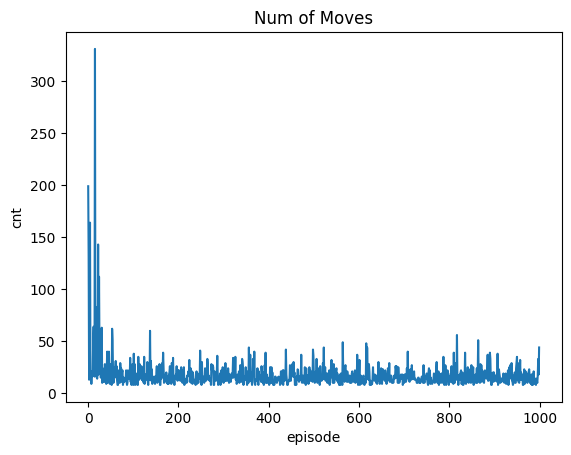

In [19]:
#1000번의 에피소드에서 에이전트의 이동 횟수를 시각화
#total_move에는 에피소드마다 얼마나 움직였는지를 더한다
#move_cnt에는 하나의 에피소드에 얼마나 움직였는지를 더한다

plt.plot(total_moves)
plt.ylabel('cnt')
plt.xlabel('episode')
plt.title('Num of Moves')
plt.show()